In [1]:
import math

import arguebuf as ab
from util import normalize

graph = ab.load.file("../data/graphs/kialo-graphnli/10035.json")
mj = [n for n in graph.nodes if len(graph.outgoing_nodes(n)) == 0][0]
major_claim = graph.nodes[mj]
normalize(graph)

In [2]:
from typing import Literal
class Node:
    children = []
    x = 0
    y = 0
    w = 0
    text = ""
    node_type = "i"
    sticky = False
    span = 0

    def set_ll_width(self, x: float, y: float, w: float):
        self.x, self.y, self.w = x,y,w

    def __init__(self, label, type: Literal["i", "a", "s"], children: list) -> None:
        self.text = label
        self.node_type = type
        self.children = children


In [3]:
layers = [[major_claim]]
children_from_this_layer = True
current_depth = 1
while children_from_this_layer:
    children_from_this_layer = False
    new_layer = []
    for node in layers[current_depth-1]:
        for child in graph.incoming_nodes(node):
            new_layer.append(child)
            children_from_this_layer = True
    if children_from_this_layer:
        layers.append(new_layer)
    current_depth += 1
layers

[[AtomNode(10035.1, All couples should sign a prenuptial agreement before marriage.)],
 [SchemeNode(10035.2,10035.1, Support, Default),
  SchemeNode(10035.13,10035.1, Attack, Default),
  SchemeNode(10035.102,10035.1, Support, Default),
  SchemeNode(10035.6,10035.1, Attack, Default),
  SchemeNode(10035.12,10035.1, Attack, Default),
  SchemeNode(10035.8,10035.1, Support, Default),
  SchemeNode(10035.63,10035.1, Attack, Default),
  SchemeNode(10035.3,10035.1, Support, Default),
  SchemeNode(10035.31,10035.1, Attack, Default),
  SchemeNode(10035.90,10035.1, Attack, Default),
  SchemeNode(10035.93,10035.1, Attack, Default),
  SchemeNode(10035.4,10035.1, Support, Default),
  SchemeNode(10035.5,10035.1, Attack, Default),
  SchemeNode(10035.7,10035.1, Support, Default),
  SchemeNode(10035.107,10035.1, Support, Default)],
 [AtomNode(10035.2, Prenuptial agreement is the fairest way of dividing property in cases of divorce.),
  AtomNode(10035.13, It can be difficult to project into the future abo

In [4]:
def convert(graph: ab.Graph, node: ab.AbstractNode) -> Node:
    node_type = "i"
    if isinstance(node, ab.SchemeNode):
        node_type = "a" if node.label == "Attack" else "s"
    new_node = Node(node.label, node_type, [convert(graph, c) for c in graph.incoming_nodes(node)])
    return new_node

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

W = 10
H = 10
h = H / len(layers)
gamma = 0
rho = 0.5

inode_colors = {
    0: "#deebf7",
    1: "#9ecae1",
    2: "#3182bd",
}
attack_colors = {
    0: "#fee0d2",
    1: "#fc9272",
    2: "#de2d26",
}
support_colors = {
    0: "#e5f5e0",
    1: "#a1d99b",
    2: "#31a354",
}

def select_color(node, idx):
    if node.node_type == "i":
        return inode_colors[idx % 3]
    elif node.node_type == "a":
        return attack_colors[idx % 3]
    else:
        return support_colors[idx % 3]

def SRIP1(r: Node): # root
    plot = plt.figure()
    _, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, W)
    ax.set_ylim(0, H)
    ax.set_axis_off()
    # remove white border
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    points = [(0,0), (W, 0), (W, h), (0,h)]
    ax.add_patch(patches.Polygon(points, fill=False))
    r.set_ll_width(0,h,W)
    if len(r.children) > 0:
        SRIP1_r(1, [r], len(r.children), W, ax)
    plot.show()


def SRIP1_r(d: float, P: list[Node], m: int, w: float, ax):
    U = w - (m-1)*gamma
    x, y = (W-w)/2, (d+1)*h
    P2, w2, m2 = [], 0, 0

    for p in P:
        p0 = (p.x, p.y)
        for idx, c in enumerate(p.children):
            p1 = (p0[0] + 1 / len(p.children) * p.w, p0[1])
            tri = U / m
            points = [p0, p1, (x + tri, y), (x,y)]
            ax.add_patch(patches.Polygon(points, fill=False))
            c.set_ll_width(x, y, tri)
            x, p0, n = x + tri + gamma, p1, len(c.children)
            if (n > 0):
                P2, w2, m2 = P2 + [c], w2 + tri, m2 + n
    if m2 > 0:
        SRIP1_r(d+1, P2, m2, w2, ax)


<Figure size 640x480 with 0 Axes>

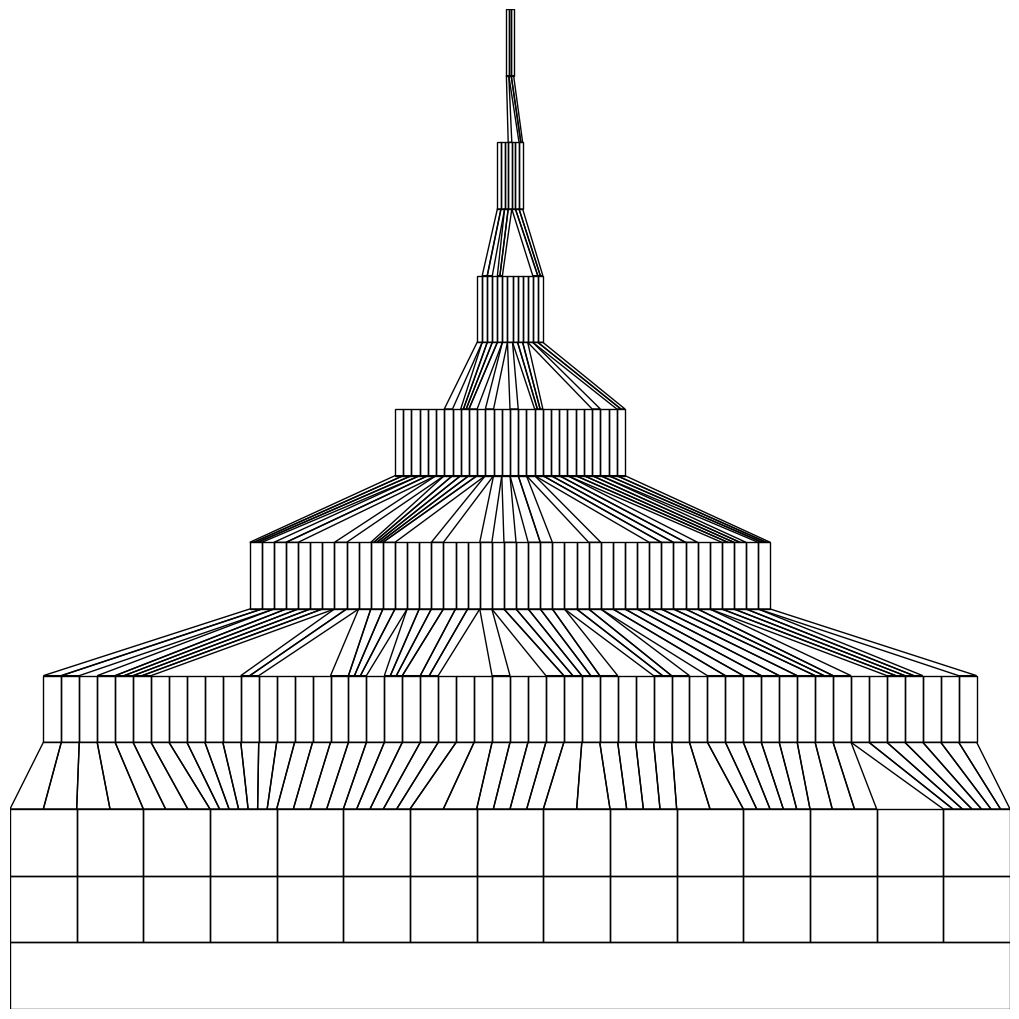

In [6]:
root = convert(graph, major_claim)
SRIP1(root)

In [7]:
W = 10
H = 10
h = H / len(layers)
epsilon = W
gamma = 0
rho = 0.5
sigma = 0.25
lambda_ = 1

def weight(x: Node | list[Node]) -> float:
    if(isinstance(x, Node)):
        return 1
    return len(x)

def SRIP2(r: Node): # root
    plot = plt.figure()
    _, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, W)
    ax.set_ylim(H, 0)
    ax.set_axis_off()
    # remove white border
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    # computeWeights()
    o = (W - epsilon) / 2

    points = [(o,0), (W-o, 0), (W-o, h), (o,h)]
    ax.add_patch(patches.Polygon(points, fill=False))
    r.set_ll_width(0,h,W)
    C = r.children
    if len(C) > 0:
        SRIP2_r(1, [r], len(C), weight(C), W, 0, ax)
    plot.show()


def SRIP2_r(d: float, P: list[Node], m: int, A: float, w: float, g: float, ax):
    gamma_d = 0
    if m > 1:
        gamma_d = max(0, min(gamma, math.floor((w-g-m)/(m-1))))
    if gamma_d == 0 and g > w:
        w = g
    U = w - g - (m-1) * gamma_d
    x, y = (W-w)/2, (d+1)*h
    P2, m2, A2, w2, g2 = [], 0, 0, 0, 0
    for p in P:
        p0 = (p.x, p.y)
        if p.sticky:
            C = [p]
        else:
            C = p.children
        for c in C:
            if c.sticky:
                p1 = (p0[0] + p.w, p0[1])
                c.set_ll_width(x, y, sigma*p.w)
                x, c.span = x+ c.w, c.span+1
            else:
                p1 = (p0[0] + (weight(c)/weight(C) * p.w), p0[1])
                tri = weight(c)/A*U
                delta = min(tri, epsilon)
                o = (tri- delta) / 2
                points = [p0, p1, (x+o+delta, y), (x+ o, y)]
                # print(points)
                ax.add_patch(patches.Polygon(points, fill=False))
                c.set_ll_width(x+o,y,delta)
                x = x + tri + gamma_d
            p0, C2, n = p1, c.children, len(c.children)
            c.sticky = n == 0
            if c.sticky and c.span < lambda_:
                P2, g2 = P2 + [c], g2 + c.w
            if not c.sticky:
                P2, m2, A2, w2 = P2 + [c], m2 + n, A2 + weight(C2), w2 + tri
    if m2 > 0:
        SRIP2_r(d+1, P2, m2, A2, w2 + rho * (W-w2), sigma * g2, ax)

<Figure size 640x480 with 0 Axes>

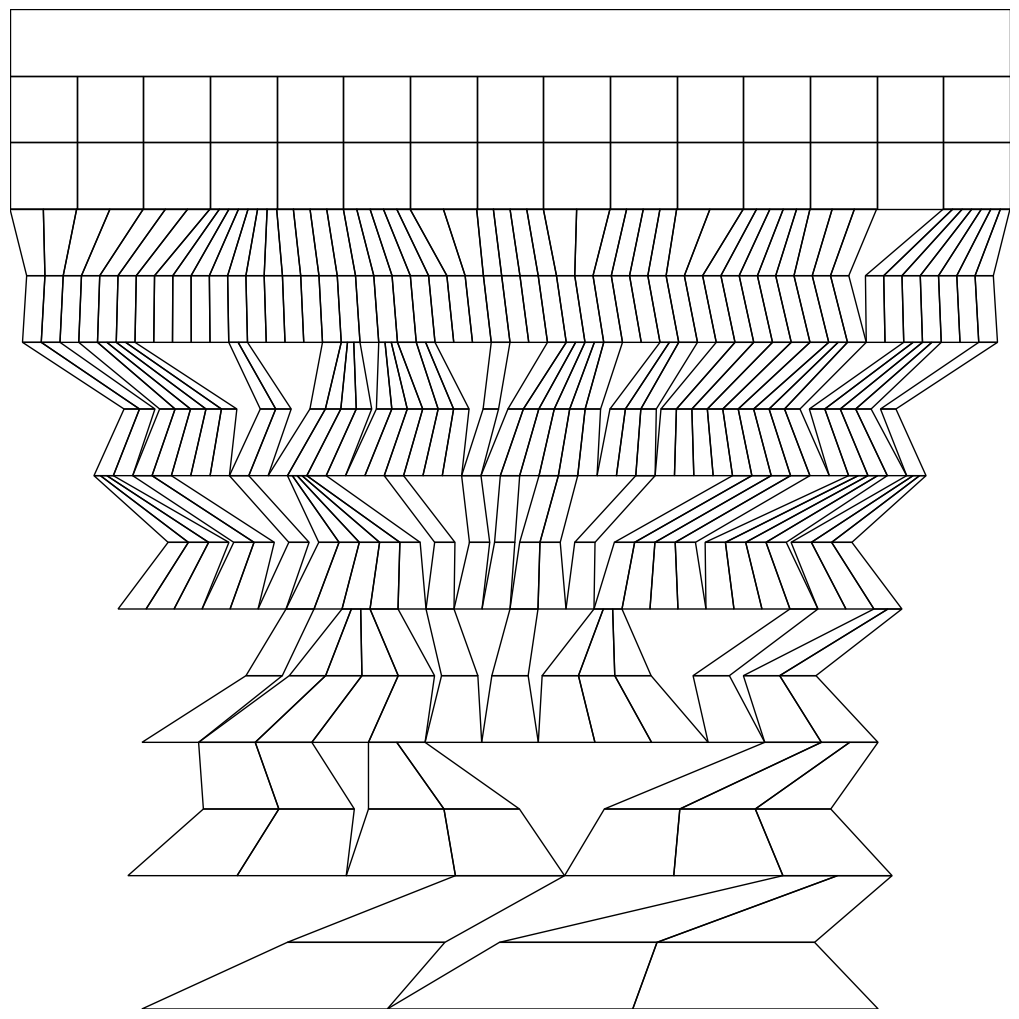

In [8]:
SRIP2(root)

<Figure size 640x480 with 0 Axes>

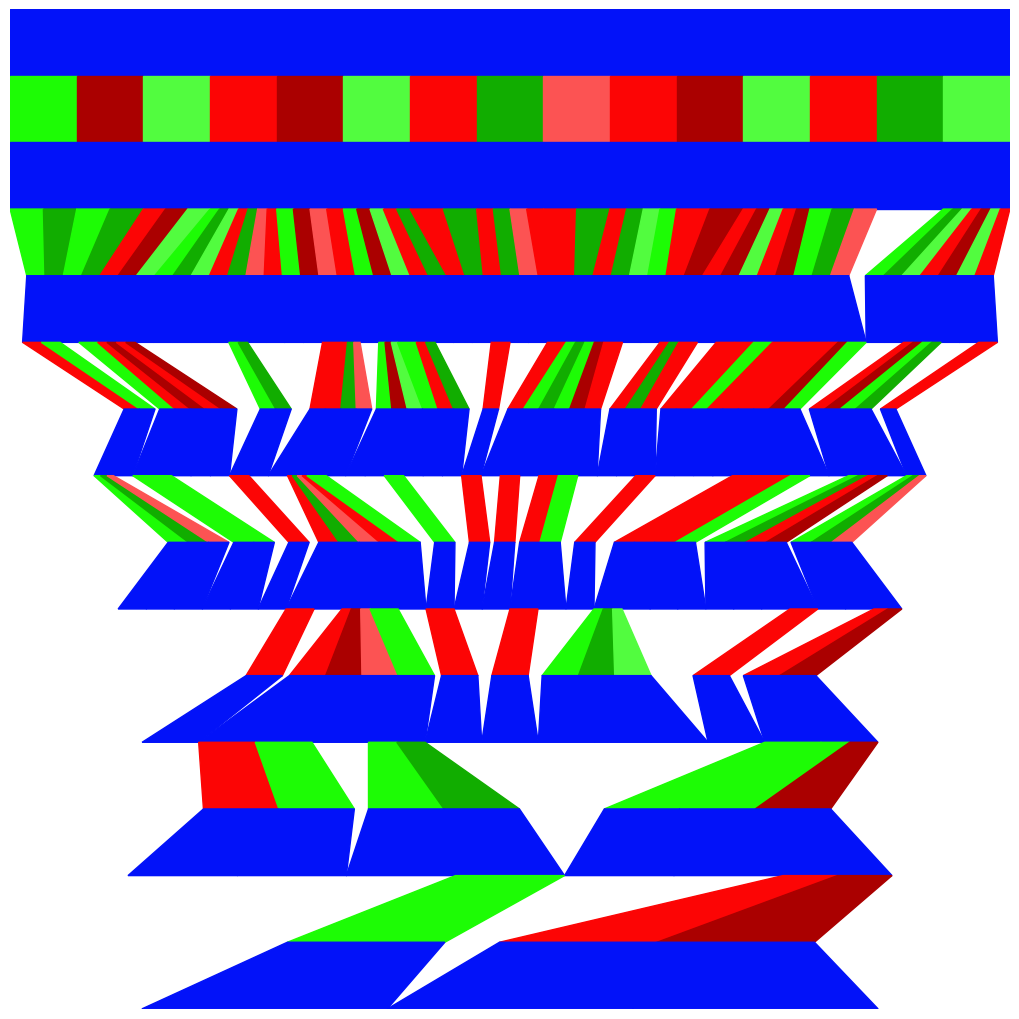

In [9]:
from pathlib import Path
from srip import SRIP2, convert_from_AbstractNode_to_Node, Node

root = convert_from_AbstractNode_to_Node(graph, major_claim)

p = Path("test.png")
fun = lambda x: 1 if isinstance(x, Node) else len(x)
SRIP2(root, graph, p, fun)

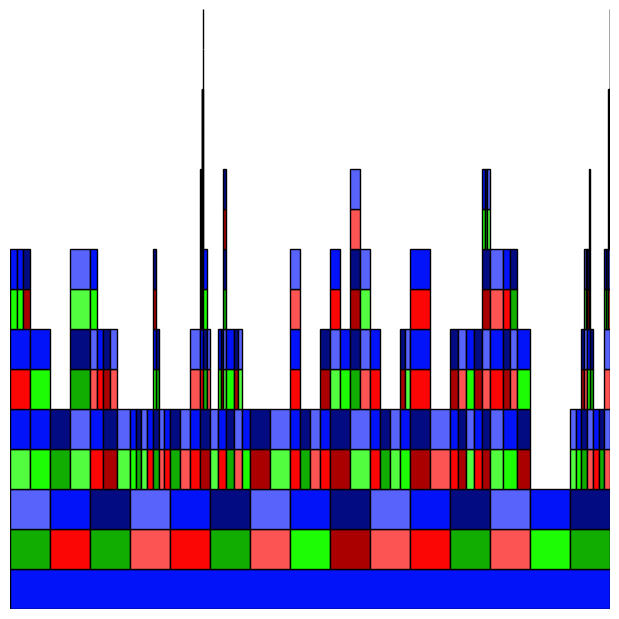

In [10]:
from logical import render
render(graph, Path("test.png"))

<Figure size 640x480 with 0 Axes>

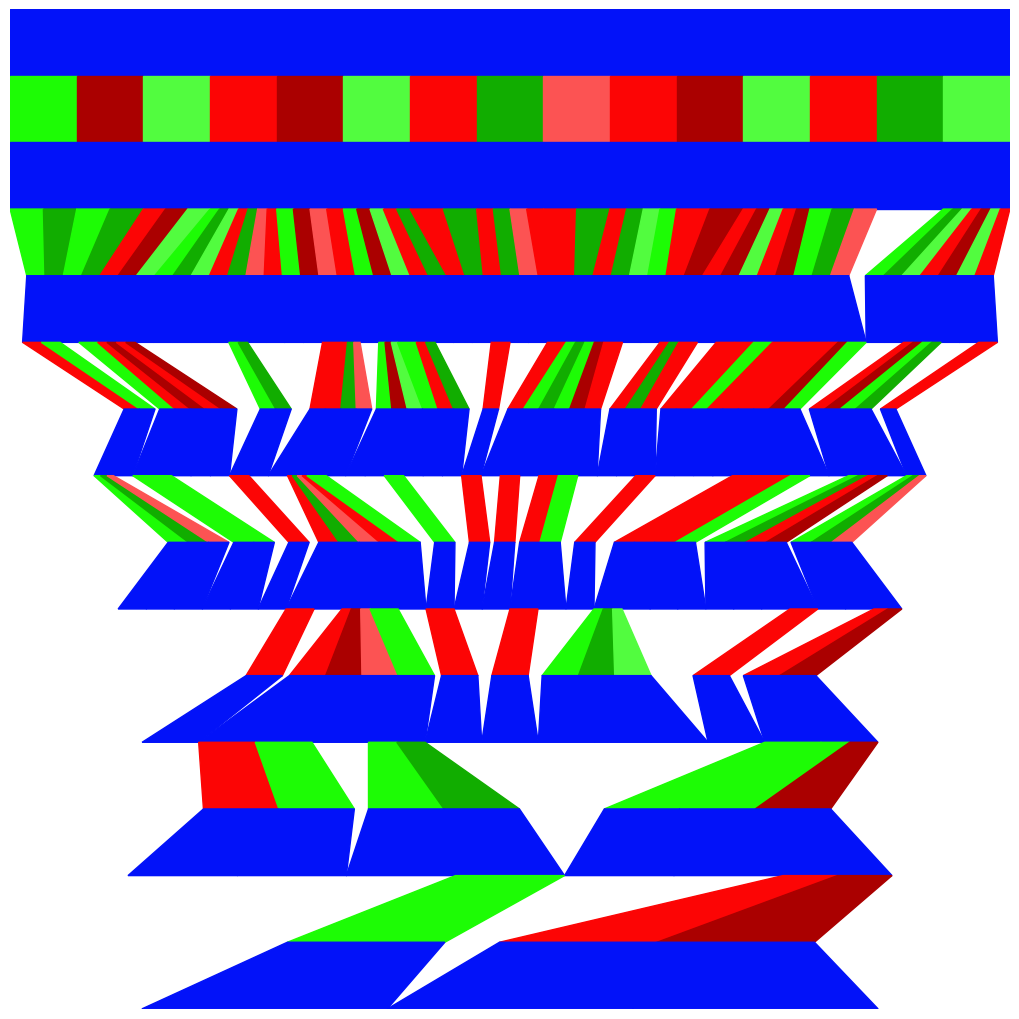

In [11]:
from srip import SRIP2, convert_from_AbstractNode_to_Node, Node
root = convert_from_AbstractNode_to_Node(graph, major_claim)
p = Path("test.png")
SRIP2(root, graph, p, lambda x: 1 if isinstance(x, Node) else len(x))